## Metric Learning

In [1]:
import os
import os.path
import sys
from IPython.display import clear_output
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data.sampler import Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from data_util.npair_dataset import FramePairsDataset
from data_util.npair_sampler import VideoFrameSampler
import data_util.simclr_transforms as custom_transform

train_dir = '../data/mnist/mnist_png/training'
val_dir = '../data/mnist/mnist_png/testing'

batch_size = 10
frames_per_epoch = 400

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = FramePairsDataset(train_dir, '.png', distance=15, transform=transform)
sampler = VideoFrameSampler(len(dataset), frames_per_epoch, 6000)
data_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

In [3]:
val_dataset = FramePairsDataset(val_dir, '.png', distance=15, transform=transform)
val_sampler = VideoFrameSampler(len(val_dataset), 100, 1000)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, sampler=val_sampler)

### Model and Optimizer

In [5]:
from model.mnist_model import NetWithoutBatchNorm
from loss.npair_loss import NPairLoss

model = NetWithoutBatchNorm()
print(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)
criterion = NPairLoss(device, batch_size, .001)

NetWithoutBatchNorm(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (g): Linear(in_features=10, out_features=3, bias=True)
)


### Training the Network

In [6]:
n_pairs_per_epoch = len(sampler)/batch_size
def train(epoch):
    model.train()
    running_loss = 0.0
    lr = optimizer.param_groups[0]['lr']
    for batch_frames in data_loader:
        optimizer.zero_grad()
        anchors = batch_frames[0]
        positives = batch_frames[1]
        anchors, positives = anchors.to(device), positives.to(device)
        r_anchors, r_positives = model(anchors), model(positives)
        loss, accuracy = criterion(r_anchors, r_positives)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: %3d | Avg Loss: %f | LR : %.9f" 
          % (epoch, running_loss/n_pairs_per_epoch, lr))
    return running_loss


def validation():
    scheduler.step()
    accuracy = 0.0
    for batch_frames in val_loader:
        with torch.no_grad():
            anchors = batch_frames[0]
            positives = batch_frames[1]
            anchors, positives = anchors.to(device), positives.to(device)
            r_anchors, r_positives = model(anchors), model(positives)
            loss, acc = criterion(r_anchors, r_positives)
            accuracy += acc
    return accuracy

model_file = 'mnist.pth'

In [7]:
epochs = 25
max_accuracy = 0
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_losses.append(train(epoch))
    accuracy = validation()
    test_accuracies.append(accuracy)
    print("Accuracy = %f" %(accuracy))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        print("Saving model to %s. Accuracy = %f." %(model_file, accuracy))
        torch.save(model.state_dict(), model_file)

Epoch:   0 | Avg Loss: 1.936302 | LR : 0.001000000
Accuracy = 56.649990
Saving model to mnist.pth. Accuracy = 56.649990.
Epoch:   1 | Avg Loss: 1.301543 | LR : 0.001000000
Accuracy = 72.100014
Saving model to mnist.pth. Accuracy = 72.100014.
Epoch:   2 | Avg Loss: 0.942612 | LR : 0.001000000
Accuracy = 77.500008
Saving model to mnist.pth. Accuracy = 77.500008.
Epoch:   3 | Avg Loss: 0.675447 | LR : 0.001000000
Accuracy = 86.649994
Saving model to mnist.pth. Accuracy = 86.649994.
Epoch:   4 | Avg Loss: 0.526096 | LR : 0.001000000
Accuracy = 88.850006
Saving model to mnist.pth. Accuracy = 88.850006.
Epoch:   5 | Avg Loss: 0.391044 | LR : 0.000100000
Accuracy = 91.499992
Saving model to mnist.pth. Accuracy = 91.499992.
Epoch:   6 | Avg Loss: 0.329699 | LR : 0.000100000
Accuracy = 92.849998
Saving model to mnist.pth. Accuracy = 92.849998.
Epoch:   7 | Avg Loss: 0.275683 | LR : 0.000100000
Accuracy = 94.499962
Saving model to mnist.pth. Accuracy = 94.499962.
Epoch:   8 | Avg Loss: 0.296766 

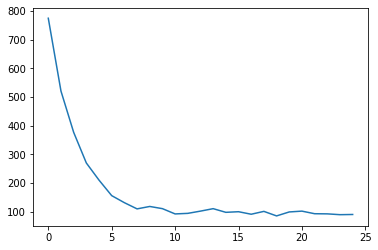

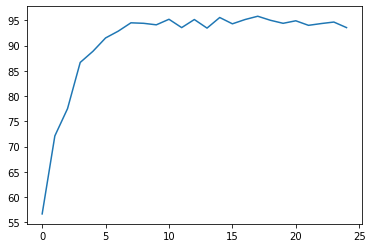

In [8]:
plt.plot(train_losses)
plt.show()
plt.plot(test_accuracies)
plt.show()

## Visualization

### Create Model and Load Weights

In [ ]:
from model.mnist_model import NetWithoutBatchNorm
model = NetWithoutBatchNorm()
# Load weigths from the model trained on upstream task
model_file = './mnist.pth'
state_dict = torch.load(model_file)
model.load_state_dict(state_dict)

# Decide whether to freeze or finetune the model
for param in model.parameters():
    param.requires_grad = False

model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)

In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, sampler=val_sampler)